In [1]:
from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from desc.plotting import plot_section, plot_3d, plot_surfaces, plot_2d, plot_boundary, plot_1d
from matplotlib import pyplot as plt 

DESC version 0+untagged.5777.g1c062d7,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 2.19 GB available memory


In [2]:
def chebygrid(N_grid):
    return np.concatenate( ([0],(-np.cos( (2 * np.arange(N_grid) + 1) * np.pi / (2 *  N_grid) ) + 1) * np.pi ,[2*np.pi]))
def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid,M=M_grid,N=0, node_pattern=node_pattern).nodes[:,:2]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size,1))
    n = np.tile(Nnodes.reshape(-1,1), (1, LMnodes.shape[0])).reshape(-1,1)
    nodes = np.concatenate((lm,n), axis=1)
    return Grid(nodes)

In [3]:
def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm =0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n)*coeff[i]
    return lm

# Free End Cap condition

In [14]:
from scipy.constants import mu_0

In [23]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1, 0.5],
    modes_Z=[[0,0],[-1,0], [-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)

p = PowerSeriesProfile(params=[0.001/mu_0, -0.001/mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.2, 0])
eq = Equilibrium(
    surface=surf,
    L=6,
    M=1,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
)

constraints = (
        # FixEndCapLambda(0, eq=eq),
        # FixEndCapR(0, eq.eq),
        # FixEndCapZ(0, eq=eq),
        # FixEndCapLambda(2*np.pi, eq=eq),
        # FixEndCapR(2*np.pi, eq=eq),
        # FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(10,4,10)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [24]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 216
Number of objectives: 1152
Starting optimization
Using method: lsq-exact
         Current function value: 1.415e-10
         Total delta_x: 3.542e-01
         Iterations: 100
         Function evaluations: 120
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  9.036e-01, 
Maximum absolute Force error:  9.545e+05 (N)
Minimum absolute Force error:  0.000e+00 (N)
Average absolute Force error:  8.058e+04 (N)
Maximum absolute Force error:  1.153e-01 (normalized)
Minimum absolute Force error:  0.000e+00 (normalized)
Average absolute Force error:  9.736e-03 (normalized)
End of solver
Total (sum of squares):  1.415e-10, 
Maximum absolute Force error:  2.108e+01 (N)
Minimum absolute Force error:  1.748e-03 (N)
Average absolute Force error:  1.641e+00 (N)
Maximum absolute Force error:  2.547e-06 (normalized)
Minimum absolute Force error:  2.

(<Figure size 431.653x431.653 with 2 Axes>,
 <Axes3D: title={'center': '$\\alpha~(~)$'}, xlabel='$X ~(\\mathrm{m})$', ylabel='$Y ~(\\mathrm{m})$', zlabel='$Z ~(\\mathrm{m})$'>)

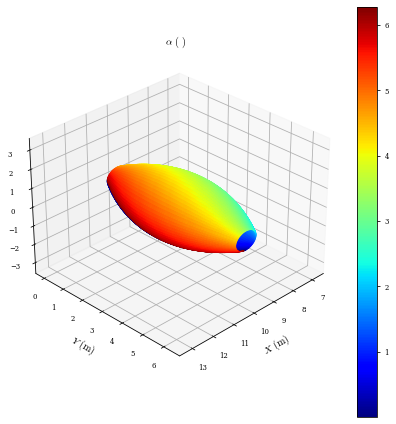

In [25]:
plot_3d(eq, "alpha", azim=45)

(<Figure size 287.769x287.769 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ p ~(Pa)$'>)

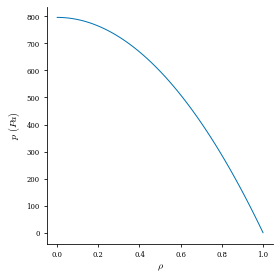

In [26]:
plot_1d(eq, "p")

(<Figure size 1079.13x719.422 with 11 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.250$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.750$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

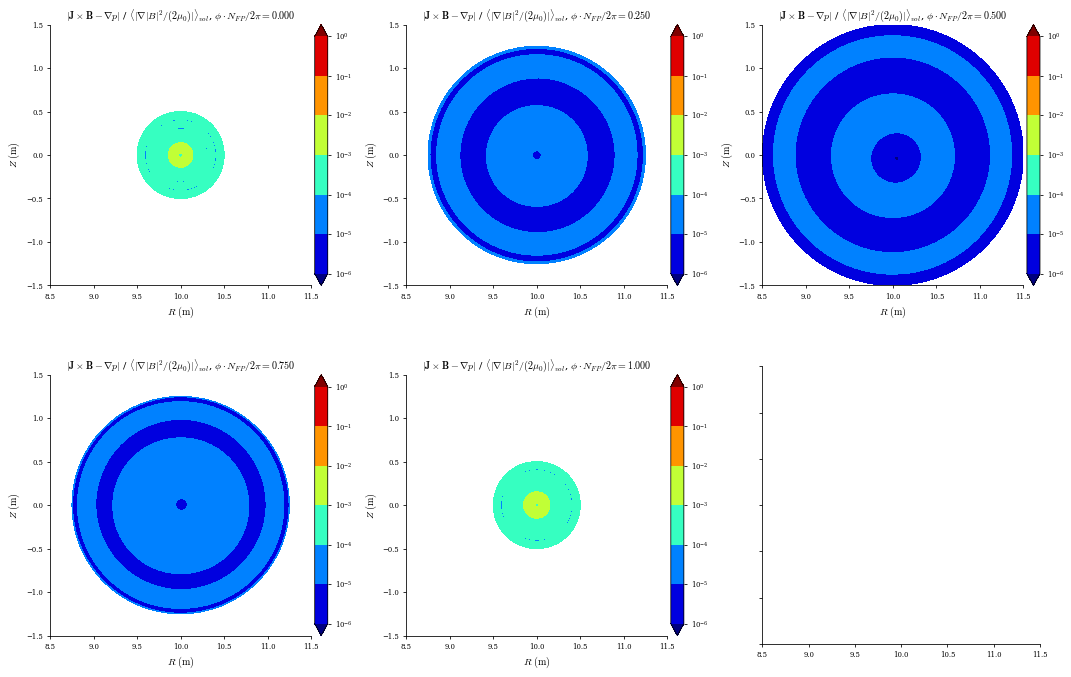

In [27]:
plot_section(eq, "|F|", norm_F=True, log=True, grid=LinearGrid(L=50,M=50,N=2,endpoint=True))

# Fix B.C.

In [28]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1, 0.5],
    modes_Z=[[0,0],[-1,0], [-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)

p = PowerSeriesProfile(params=[0.001/mu_0, -0.001/mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.2, 0])
eq = Equilibrium(
    surface=surf,
    L=6,
    M=1,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
)

constraints = (
        FixEndCapLambda(0, eq=eq),
        FixEndCapR(0, eq.eq),
        FixEndCapZ(0, eq=eq),
        FixEndCapLambda(2*np.pi, eq=eq),
        FixEndCapR(2*np.pi, eq=eq),
        FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(12,2,16)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [29]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 168
Number of objectives: 1152
Starting optimization
Using method: lsq-exact
         Current function value: 1.635e-01
         Total delta_x: 6.388e-01
         Iterations: 100
         Function evaluations: 108
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  9.036e-01, 
Maximum absolute Force error:  9.545e+05 (N)
Minimum absolute Force error:  0.000e+00 (N)
Average absolute Force error:  8.058e+04 (N)
Maximum absolute Force error:  1.153e-01 (normalized)
Minimum absolute Force error:  0.000e+00 (normalized)
Average absolute Force error:  9.736e-03 (normalized)
End of solver
Total (sum of squares):  1.635e-01, 
Maximum absolute Force error:  2.836e+05 (N)
Minimum absolute Force error:  3.047e+01 (N)
Average absolute Force error:  5.619e+04 (N)
Maximum absolute Force error:  3.427e-02 (normalized)
Minimum absolute Force error:  3.

(<Figure size 1079.13x719.422 with 11 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.250$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.750$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

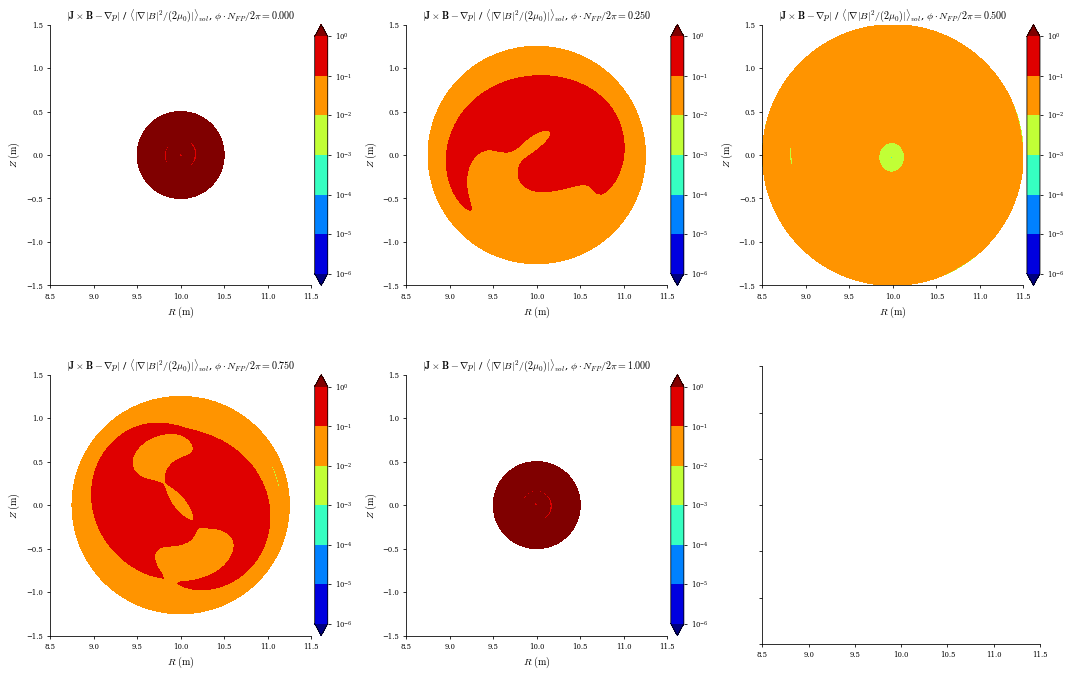

In [30]:
plot_section(eq, "|F|", norm_F=True, log=True, grid=LinearGrid(L=50,M=50,N=2,endpoint=True))

# Fix End Cap boundary condition

In [4]:
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1,0.5],
    modes_Z=[[0,0],[-1,0],[-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)

p = PowerSeriesProfile(params=[0, 0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.1, 0])
eq = Equilibrium(
    surface=surf,
    L=7,
    M=1,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
    method="jitable",
)

constraints = (
        FixEndCapLambda(0, eq=eq),
        FixEndCapR(0, eq=eq),
        FixEndCapZ(0, eq=eq),
        FixEndCapLambda(2*np.pi, eq=eq),
        FixEndCapR(2*np.pi, eq=eq),
        FixEndCapZ(2*np.pi, eq=eq),
        FixBoundaryR(eq=eq),
        FixBoundaryZ(eq=eq),
        FixPressure(eq=eq),
        FixIota(eq=eq),
        FixPsi(eq=eq),
    )
optimizer = Optimizer("lsq-exact")
grid = grid_gen(14,2,2)
# objectives = CurrentDensity(eq=eq, grid=grid)
objectives = ForceBalance(eq=eq, grid=grid)
obj = ObjectiveFunction(objectives=objectives)

In [5]:
eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-6,
    xtol=1e-16,
    gtol=1e-16,
);

Building objective: force
Precomputing transforms
Compiling objective function and derivatives: ['force']
Number of parameters: 210
Number of objectives: 192
Starting optimization
Using method: lsq-exact
         Current function value: 8.497e-11
         Total delta_x: 5.126e-01
         Iterations: 100
         Function evaluations: 118
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  1.092e+00, 
Maximum absolute Force error:  9.704e+05 (N)
Minimum absolute Force error:  1.766e-12 (N)
Average absolute Force error:  1.001e+05 (N)
Maximum absolute Force error:  1.207e-01 (normalized)
Minimum absolute Force error:  2.197e-19 (normalized)
Average absolute Force error:  1.245e-02 (normalized)
End of solver
Total (sum of squares):  8.497e-11, 
Maximum absolute Force error:  2.307e+01 (N)
Minimum absolute Force error:  1.152e-04 (N)
Average absolute Force error:  6.821e-01 (N)
Maximum absolute Force error:  2.870e-06 (normalized)
Minimum absolute Force error:  1.4

(<Figure size 575.538x575.538 with 2 Axes>,
 <Axes3D: title={'center': '$\\alpha~(~)$'}, xlabel='$X ~(\\mathrm{m})$', ylabel='$Y ~(\\mathrm{m})$', zlabel='$Z ~(\\mathrm{m})$'>)

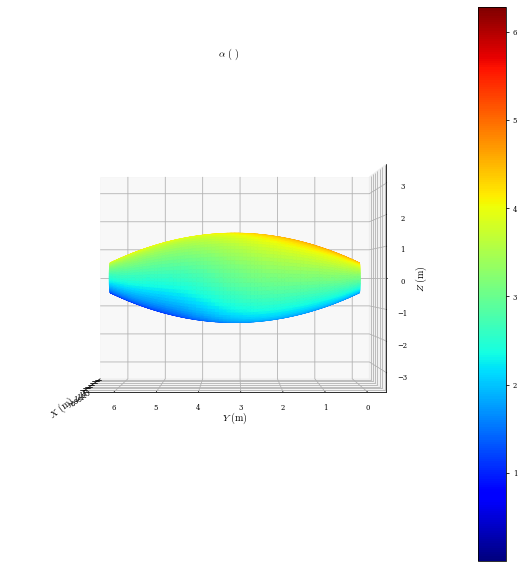

In [6]:
plot_3d(eq, "alpha", azim=180,elev=0, figsize=(8,8))

(<Figure size 1079.13x719.422 with 12 Axes>,
 array([<Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$|\\mathbf{J} \\times \\mathbf{B} - \\nabla p|$ / $\\langle |\\nabla |B|^{2}/(2\\mu_0)| \\rangle_{vol}$, $\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Ax

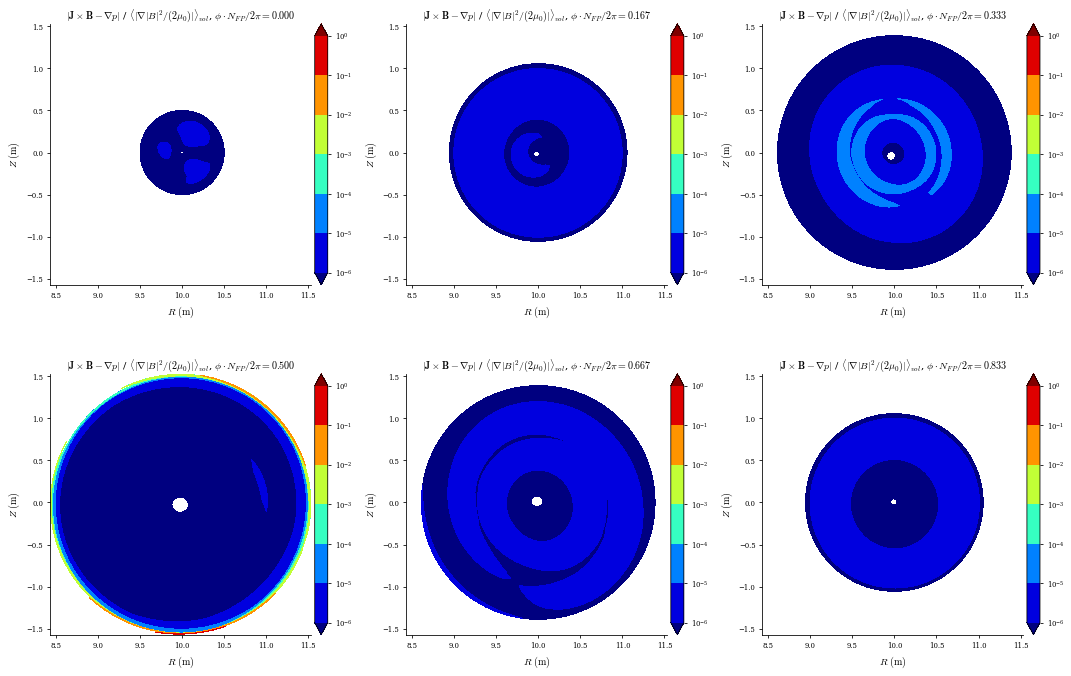

In [8]:
plot_section(eq,"|F|", norm_F=True, log=True)